# Boost factors

In [1]:
import clmm
from clmm import Cosmology
from clmm.support import mock_data as mock
from clmm.galaxycluster import GalaxyCluster
import matplotlib.pyplot as plt
import sys
import clmm.utils as u

Make sure we know which version we're using

In [2]:
clmm.__version__

'1.4.8'

### Define cosmology object

In [3]:
mock_cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)

First, we want to generate a $\Delta\Sigma$ (excess surface density) profile from mock data, to which we can apply boost factors. The mock data is generated in the following cells.

Generate cluster object from mock data

In [4]:
cosmo = mock_cosmo
cluster_id = "Awesome_cluster"
cluster_m = 1.e15
cluster_z = 0.3
concentration = 4
ngals = 1000

zsrc_min = cluster_z + 0.1 # we only want to draw background galaxies

noisy_data_z = mock.generate_galaxy_catalog(cluster_m,
                                            cluster_z,
                                            concentration,
                                            cosmo,
                                            'chang13',
                                            zsrc_min=zsrc_min,
                                            shapenoise=0.005,
                                            photoz_sigma_unscaled=0.05, ngals=ngals)

Loading this into a CLMM cluster object centered on (0,0)

In [5]:
cluster_ra = 0.0
cluster_dec = 0.0
cl = GalaxyCluster(cluster_id, cluster_ra, cluster_dec, 
                               cluster_z, noisy_data_z)

Compute cross and tangential excess surface density for each source galaxy

In [6]:
_ = cl.compute_tangential_and_cross_components(
    geometry="flat", shape_component1='e1', shape_component2='e2', 
    tan_component='DeltaSigma_tan', cross_component='DeltaSigma_cross',
    add=True, cosmo=cosmo, is_deltasigma=True)

/pbs/home/e/ebarroso/.local/lib/python3.11/site-packages/clmm-1.4.8-py3.11.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.


Calculate the binned profile

In [7]:
cl.make_radial_profile("kpc", cosmo=cosmo, 
                       tan_component_in='DeltaSigma_tan', cross_component_in='DeltaSigma_cross',
                       tan_component_out='DeltaSigma_tan', cross_component_out='DeltaSigma_cross',
                       table_name='DeltaSigma_profile')
# Format columns for display
for col in cl.DeltaSigma_profile.colnames:
    fmt = cl.DeltaSigma_profile[col].info.format
    if 'DeltaSigma' in col:
        fmt = '.2e'
    elif any(typ in col for typ in ('z', 'radius')):
        fmt = '.2f'
    cl.DeltaSigma_profile[col].info.format = fmt
# Show
cl.DeltaSigma_profile.show_in_notebook()

idx,radius_min,radius,radius_max,DeltaSigma_tan,DeltaSigma_tan_err,DeltaSigma_cross,DeltaSigma_cross_err,z,z_err,n_src
0,115.98,427.41,664.30,2.07e+14,1.79e+13,5.36e+12,3.78e+12,0.96,0.08,23
1,664.30,921.98,1212.62,1.22e+14,3.81e+12,5.37e+11,2.18e+12,1.25,0.10,60
2,1212.62,1469.85,1760.95,7.85e+13,2.04e+12,-7.46e+11,1.79e+12,1.36,0.09,71
3,1760.95,2049.59,2309.27,5.78e+13,1.95e+12,-3.03e+11,1.45e+12,1.16,0.06,119
4,2309.27,2594.93,2857.59,4.40e+13,1.32e+12,6.37e+11,1.40e+12,1.34,0.07,139
5,2857.59,3160.79,3405.92,3.54e+13,1.96e+12,-1.90e+12,2.10e+12,1.22,0.06,149
6,3405.92,3680.88,3954.24,2.75e+13,1.47e+12,-2.41e+12,2.04e+12,1.28,0.06,197
7,3954.24,4205.06,4502.56,2.47e+13,1.63e+12,-9.21e+11,1.50e+12,1.33,0.07,143
8,4502.56,4760.19,5050.89,1.76e+13,2.17e+12,-5.49e+12,2.22e+12,1.32,0.12,69
9,5050.89,5198.69,5599.21,1.90e+13,2.00e+12,-4.19e+12,3.87e+12,1.49,0.14,30


Plot the $\Delta\Sigma$ profile

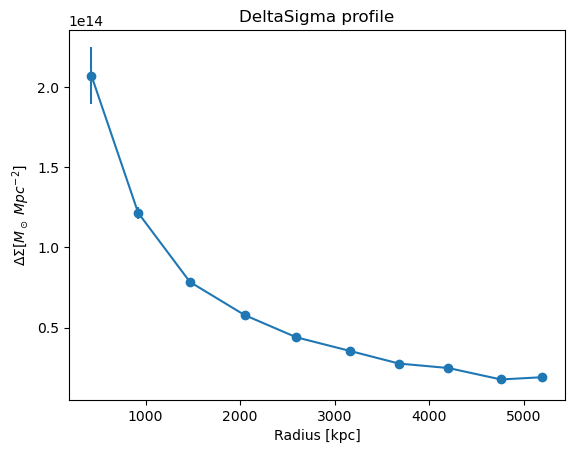

In [8]:
plt.errorbar(cl.DeltaSigma_profile['radius'], cl.DeltaSigma_profile['DeltaSigma_tan'],
             cl.DeltaSigma_profile['DeltaSigma_tan_err'], marker = 'o')

plt.title('DeltaSigma profile')
plt.xlabel("Radius [kpc]")
plt.ylabel('$\Delta\Sigma [M_\odot\; Mpc^{-2}]$')

plt.show()

## Boost Factors

CLMM offers two boost models, the NFW boost model, and a powerlaw boost model. 

Note that `compute_nfw_boost` requires two parameters to be specified, `rs` and `b0`, and `compute_powerlaw_boost` requires three paramters, `rs`, `b0` and `alpha`. The default values are in kpc. 

Details on these boost models can be found [here](https://cluster-toolkit.readthedocs.io/en/latest/source/boostfactors.html)

First, we can calculate the boost factors from the two models.

In [9]:
nfw_boost = u.compute_nfw_boost(cl.DeltaSigma_profile['radius'],rs=1000, b0=0.1)

powerlaw_boost = u.compute_powerlaw_boost(cl.DeltaSigma_profile['radius'],rs=1000, b0=0.1, alpha=-1.0)

Plot the two boost factors, $B(R)$

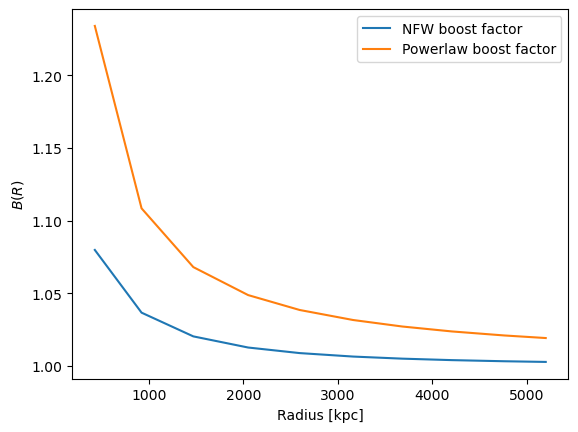

In [10]:
plt.plot(cl.DeltaSigma_profile['radius'],nfw_boost,label='NFW boost factor')
plt.plot(cl.DeltaSigma_profile['radius'],powerlaw_boost,label='Powerlaw boost factor')
plt.xlabel("Radius [kpc]")
plt.ylabel("$B(R)$")
plt.legend()
plt.show()

The $\Delta\Sigma$ profiles can be corrected with the boost factor using `correct_sigma_with_boost_values` or `correct_sigma_with_boost_model`. 

`correct_sigma_with_boost_values` requires us to precompute the boost factor, e.g. using `compute_nfw_boost`.
`correct_sigma_with_boost_model` simply requires us to specify the boost model.


Note that the boost factor can be used in one of two ways.

Either the boost factor can be applied to the observed data vector to correct for the dilution of the signal by cluster member galaxies. In this case the amplitude of the corrected profile will increase.

Or the boost factor can be applied to the model prediction. In this case it behaves as a dilution factor, and the resulting model prediction will be lower than the original one.

Both scenarios will improve the agreement between the mock data and observed data, by accounting for cluster member galaxy contamination.

In this notebook, we use the second approach, where the data is generated using mock data that does not account for dilution until the boost factor is applied. The corrected profiles from the mock data are lower than the uncorrected one.

Essentially we are diluting the mock profile to mimick the effect of contamination by cluster members.



First we will apply the boost factor with `correct_sigma_with_boost_values`

In [11]:
Sigma_corrected_powerlaw_boost = u.correct_sigma_with_boost_values(cl.DeltaSigma_profile['DeltaSigma_tan'],
                                                                   powerlaw_boost)
Sigma_corrected_nfw_boost = u.correct_sigma_with_boost_values(cl.DeltaSigma_profile['DeltaSigma_tan'],
                                                              nfw_boost)

Plot the result

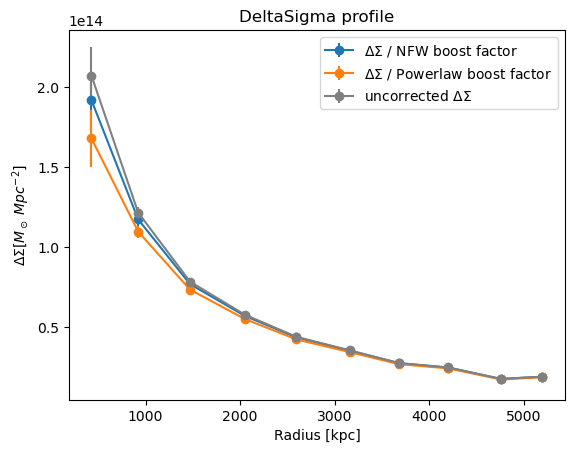

In [12]:
plt.errorbar(cl.DeltaSigma_profile['radius'], Sigma_corrected_nfw_boost,
             cl.DeltaSigma_profile['DeltaSigma_tan_err'], marker = 'o',label='$\Delta \Sigma$ / NFW boost factor')

plt.errorbar(cl.DeltaSigma_profile['radius'], Sigma_corrected_powerlaw_boost,
             cl.DeltaSigma_profile['DeltaSigma_tan_err'], marker = 'o',label='$\Delta \Sigma$ / Powerlaw boost factor')

plt.errorbar(cl.DeltaSigma_profile['radius'], cl.DeltaSigma_profile['DeltaSigma_tan'],
             cl.DeltaSigma_profile['DeltaSigma_tan_err'], marker = 'o',label='uncorrected $\Delta \Sigma$',color='grey')

#plt.loglog()
plt.title('DeltaSigma profile')
plt.xlabel("Radius [kpc]")
plt.ylabel('$\Delta\Sigma [M_\odot\; Mpc^{-2}]$')
plt.legend()
plt.show()

Now the same again but with `correct_sigma_with_boost_model`

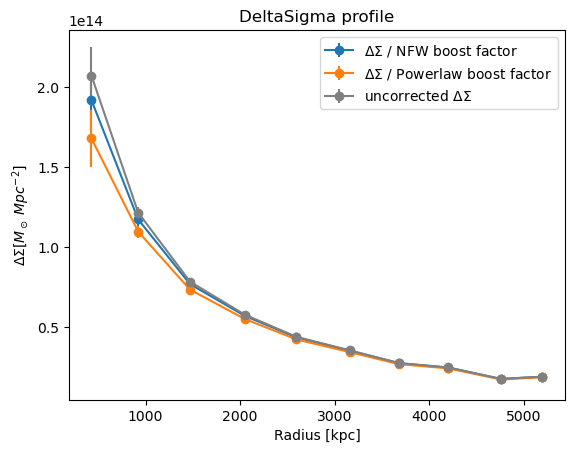

In [13]:
Sigma_corrected_powerlaw_boost = u.correct_sigma_with_boost_model(cl.DeltaSigma_profile['radius'],
                                                                   cl.DeltaSigma_profile['DeltaSigma_tan'],
                                                                   boost_model='powerlaw_boost')
Sigma_corrected_nfw_boost = u.correct_sigma_with_boost_model(cl.DeltaSigma_profile['radius'],
                                                              cl.DeltaSigma_profile['DeltaSigma_tan'],
                                                              boost_model='nfw_boost')

plt.errorbar(cl.DeltaSigma_profile['radius'], Sigma_corrected_nfw_boost,
             cl.DeltaSigma_profile['DeltaSigma_tan_err'], marker = 'o',label='$\Delta \Sigma$ / NFW boost factor')

plt.errorbar(cl.DeltaSigma_profile['radius'], Sigma_corrected_powerlaw_boost,
             cl.DeltaSigma_profile['DeltaSigma_tan_err'], marker = 'o',label='$\Delta \Sigma$ / Powerlaw boost factor')

plt.errorbar(cl.DeltaSigma_profile['radius'], cl.DeltaSigma_profile['DeltaSigma_tan'],
             cl.DeltaSigma_profile['DeltaSigma_tan_err'], marker = 'o',label='uncorrected $\Delta \Sigma$',color='grey')

#plt.loglog()
plt.title('DeltaSigma profile')
plt.xlabel("Radius [kpc]")
plt.ylabel('$\Delta\Sigma [M_\odot\; Mpc^{-2}]$')
plt.legend()
plt.show()